In [1]:
import numpy as np
import pandas as pd

import json
import ast
import gc

import seaborn
import matplotlib.pyplot as plt

from collections import Counter

from tqdm import tqdm
tqdm.pandas()

In [2]:
train_pairs = pd.read_parquet('/kaggle/input/extracted_data/train.parquet', engine='pyarrow')
test_pairs = pd.read_parquet('/kaggle/input/extracted_data/test.parquet', engine='pyarrow')

In [3]:
attrs = pd.read_parquet('/kaggle/input/extracted_data/attributes.parquet', engine='pyarrow')
text_and_bert = pd.read_parquet('/kaggle/input/extracted_data/text_and_bert.parquet', engine='pyarrow')

In [4]:
data = pd.concat(
    [
        attrs, 
        text_and_bert.drop(columns=['variantid']), 
    ], 
    axis=1
)

In [5]:
del attrs, text_and_bert
gc.collect()

0

In [6]:
# Посмотрим на пропуски в данных
data.isna().sum()

variantid                                 0
categories                                0
characteristic_attributes_mapping         0
name                                      0
description                          262398
name_bert_64                              0
dtype: int64

In [7]:
# Посмотрим на количество уникальных значений
total_count = len(data)
for col in data.columns[:5]:
    unique_count = data[col].nunique()
    percentage = (unique_count / total_count) * 100
    print(f'{col}: {unique_count} уникальных значений, что составляет {percentage:.2f}% от общего числа')

variantid: 2252569 уникальных значений, что составляет 100.00% от общего числа
categories: 3893 уникальных значений, что составляет 0.17% от общего числа
characteristic_attributes_mapping: 1911568 уникальных значений, что составляет 84.86% от общего числа
name: 1488545 уникальных значений, что составляет 66.08% от общего числа
description: 1204668 уникальных значений, что составляет 53.48% от общего числа


In [8]:
# Извлечем категории
def extract_categories(df: pd.DataFrame) -> pd.DataFrame:
    print('Извлекаю категории...')
    categories = pd.json_normalize(df['categories'].progress_apply(ast.literal_eval))
    categories.columns = [f'category_level_{i+1}' for i in range(categories.shape[1])]
    return df.drop(columns=['categories']).join(categories)

data = extract_categories(data)

Извлекаю категории...


100%|██████████| 2252569/2252569 [01:03<00:00, 35451.59it/s]


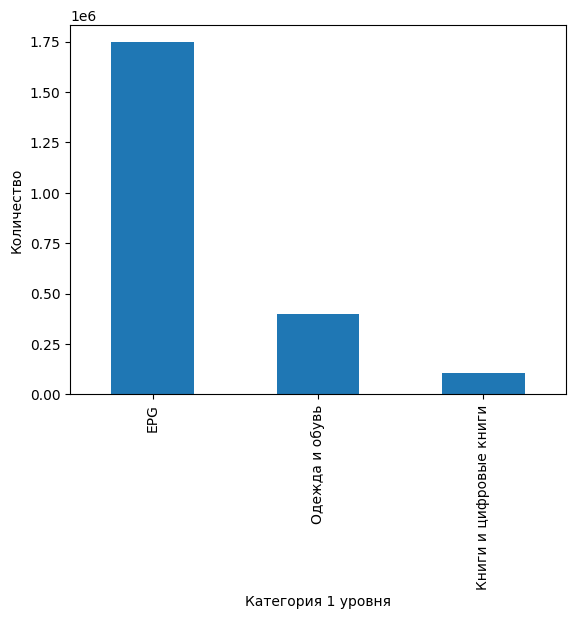

In [9]:
# Распределение категорий 1 уровня
data['category_level_1'].value_counts().plot(kind='bar')

plt.xlabel('Категория 1 уровня')
plt.ylabel('Количество')
plt.show()

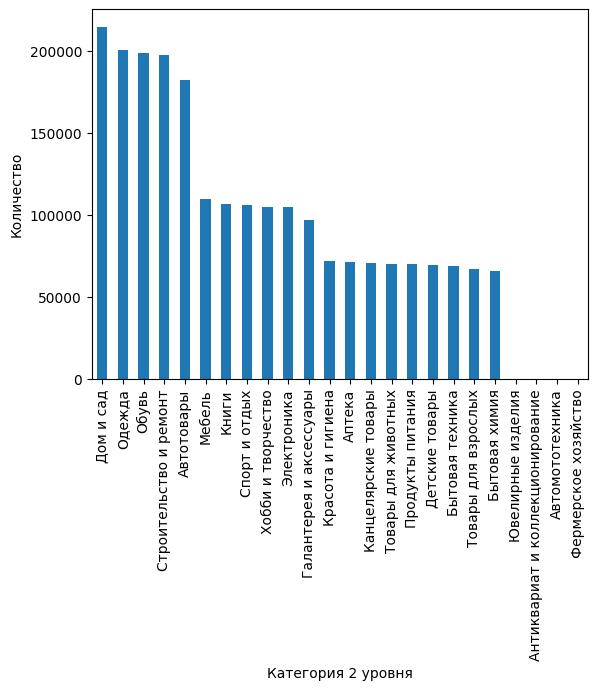

In [10]:
# Распределение категорий 2 уровня
data['category_level_2'].value_counts().plot(kind='bar')

plt.xlabel('Категория 2 уровня')
plt.ylabel('Количество')
plt.show() # есть 4 категории, которые практически не имеют сэмплов трейне и вовсе не представлены в тесте

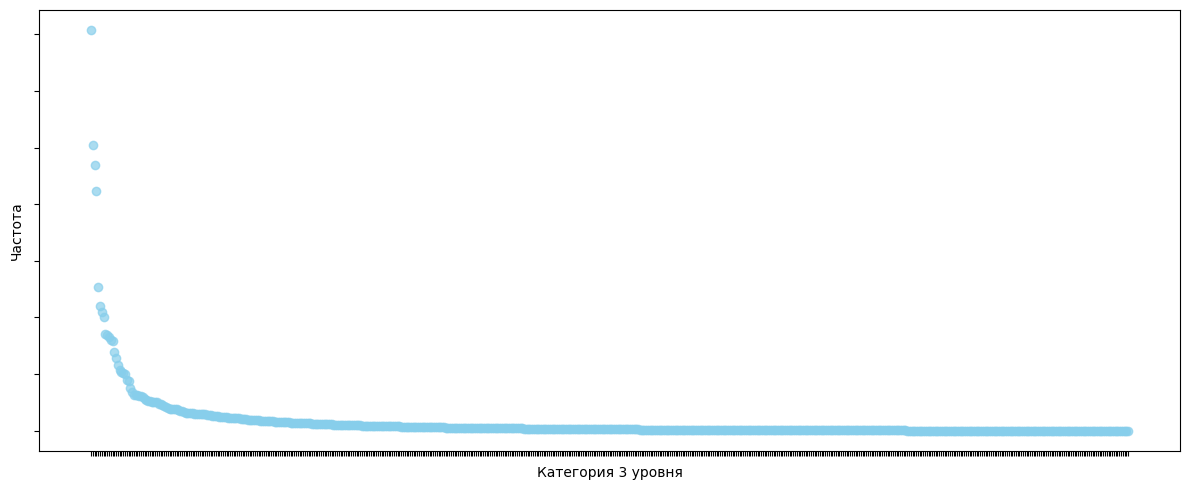

In [11]:
# Распределение категорий 2 уровня, для удобства используем scatter
counts_df = pd.DataFrame({'data': data['category_level_3'].value_counts()}).fillna(0)

fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(counts_df.index, counts_df['data'], color='skyblue', label='data', alpha=0.7)

ax.set_xlabel('Категория 3 уровня')
ax.set_ylabel('Частота')
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [12]:
# 10 самых частых категорий 3 уровня
counts_df.head(10)

,data
category_level_3,
Повседневная обувь,176865
Одежда,126291
Автозапчасти,117480
"Печатные книги, журналы, комиксы",105760
Аксессуары,63486
Моющие и чистящие средства,54985
Светильники и аксессуары,52245
Секс игрушки,50220
Игрушки,42822


In [13]:
# Самые непопулярные категории 3 уровня
counts_df[counts_df['data'] < 10]

,data
category_level_3,
Товары для молекулярной кухни,9
"Сумки, органайзеры для творчества",9
Муравьиная ферма,9
Пейнтбол,8
Водоотведение и канализация,7
Боулинг,6
Химия для творчества,5
Ювелирные украшения,5
Газоснабжение,4


In [14]:
counts_df = pd.DataFrame({'data': data['category_level_4'].value_counts()}).fillna(0)

In [15]:
# 10 самых частых категорий 4 уровня
counts_df.head(10)

,data
category_level_4,
Основные автозапчасти,62806
Кроссовки,54117
Матрас,41523
Коррегирующие очки,40916
Печатная книга: Проза других жанров,30194
Автозапчасти подвески,29665
Ботинки,28644
Светильник для дома,23369
Кружка,19496


In [16]:
# Самые непопулярные категории 4 уровня
counts_df[counts_df['data'] < 10]

,data
category_level_4,
Термометр для воды,9
Растворители оружейные,9
Текстуры,9
Зажимы для пакетов,9
Муравьиная ферма,9
...,...
"Аккумулятор для моноколеса, гироскутера",1
Шары для лототрона,1
Сумка ланчбокс,1


In [17]:
# Посмотрим на названия товаров
for i in range(20):
    print(data.iloc[i]['name'])

Игрушка для ванной , сувенир Уточка Дьяволица
Стразы(бусины) клеевые на листе 9*16 см
Набор для вышивания Vervaco "Подушка. Геометрические цветы", диаметр 40 см. PN-014483
Кружево коклюшечное "Prym", цвет: серый, 8 мм, 2 м
Оригами Настольная игра Фиксики Кодовый замок
Игра Падающая башня Классика, 54 бруска
Глина для моделирования Fimo "Soft", цвет: полупрозрачный зеленый, 56 г
Кабошон круглый, акрил, 12 мм, цвет №23 синий , 25 штук
Belashoff Одеяло 200x220 см, с наполнителем Шерсть, комплект из 1 шт
Kamjove Чайник Гунфу, 900 мл
FAVOURITE Настольная офисная лампа  Лампа настольная Favourite "Cremlin", 3 х E14, 40. 1274-3T, E14, 40 Вт
Tide Гель для стирки "Альпийская свежесть", в капсулах, 23 шт х 2 упаковки
Порошок стиральный Sano "Maxima Sensitive", концентрат, 3,25 кг
Экологичный концентрированный стиральный порошок для белого белья bioretto, "WHITE", 920 г
Стиральный порошок Losk Color, автомат для цветного белья, 2,7 кг, комплект: 3 упаковки
Лотос PRO Стиральный порошок
Постельное 

In [18]:
# Посмотрим на атрибуты товаров
for i in range(5):
    print(data.iloc[i]['characteristic_attributes_mapping'])
    print()

{"Цвет товара": ["бежевый", "светло-розовый"], "Пол ребенка": ["Унисекс"], "Бренд": ["Funny Ducks"], "Тип": ["Игрушка для ванной"], "Страна-изготовитель": ["Китай"], "Развитие навыков": ["Воображение", "Кругозор", "Моторика"], "Код ТРУ": ["320000000.03051400500000000000"], "Минимальный возраст ребенка": ["От 3 лет"], "Материал": ["ПВХ пластизоль"], "Вес товара, г": ["50"], "Максимальный возраст ребенка": ["До 18 лет"]}

{"Количество в упаковке, шт": ["1"], "Бренд": ["Нет бренда"], "Тип": ["Стразы"], "Материал": ["Акрил"], "Вес товара, г": ["20"]}

{"Бренд": ["Vervaco"], "Тип": ["Набор для вышивания"], "Страна-изготовитель": ["Бельгия"], "Материалы набора": ["Акрил", "Бумага", "Канва", "Металл", "Хлопок"], "Техника вышивки": ["Простой крест"], "Возрастные ограничения": ["От 7 лет"], "Длина по горизонтали, см": ["40"], "Длина по вертикали, см": ["40"], "Размеры, мм": ["400 х 400"]}

{"Цвет товара": ["серый"], "Ширина, см": ["0.8"], "Бренд": ["Prym"], "Тип": ["Тесьма"], "Состав ниток": ["

In [19]:
# Посмотрим на описания товаров
for i in range(228, 228 + 5):
    print(data.iloc[i]['description'])
    print()

Лёгкие и удобные мужские шорты.Средняя посадка и классический крой, трикотажное полотно из хлопка качества пенье.

Перед Вами оригинальное учебное пособие, в котором доступно и занимательно рассказывается о нескольких русских словах, их истории и особенностях современного употребления. Поэтому внимательный читатель, знакомясь с материалом данного издания, сможет лучше постичь окружающий мир, научиться сравнивать, оценивать, анализировать, осмысливать и в результате сформироваться как языковая личность. Такое понимание роли языка в процессе обучения составляет основу пособия. <br> <br>  Книга адресуется в первую очередь школьникам, студентам учебных заведений, готовящих преподавателей, журналистов, переводчиков, а также всем, кто интересуется проблемами русского языка и русскоязычной культуры. Оно будет полезно и окажет помощь тем, кто понимает, что каждый гражданин нашей Родины независимо от того, кем он работает, какой пост занимает, в каком вузе или гимназии, лицее или колледже учитс

In [20]:
# Самые частые ключи в словаре атрибутов
data['characteristic_attributes_mapping'] = data['characteristic_attributes_mapping'].apply(ast.literal_eval)

key_counter = Counter()

for mapping in data['characteristic_attributes_mapping']:
    key_counter.update(mapping.keys())

key_frequency = key_counter.most_common()

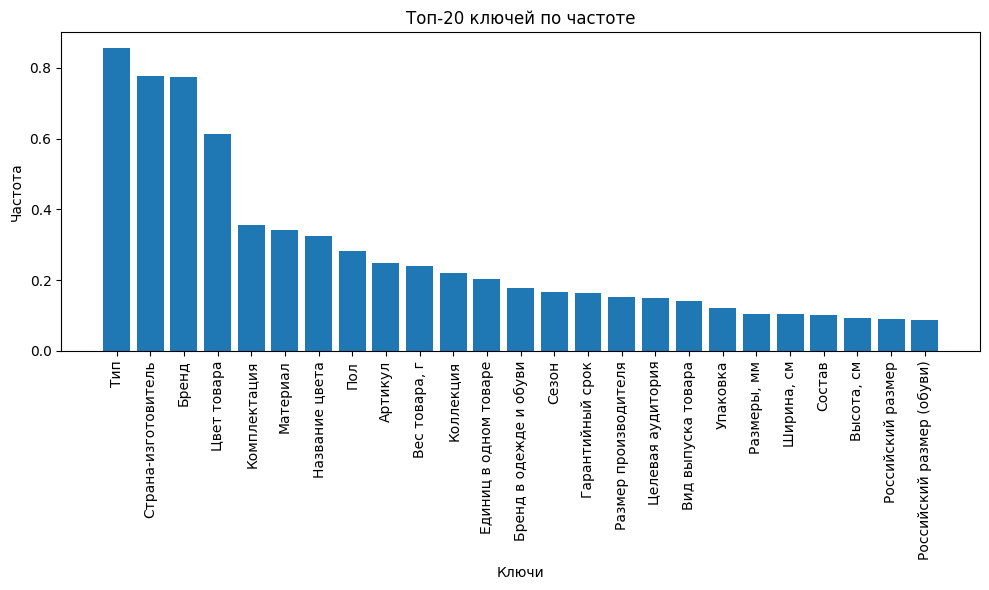

In [21]:
keys, frequencies = zip(*key_frequency[:25])
frequencies = [freq / total_count for freq in frequencies]

plt.figure(figsize=(10, 6))
plt.bar(keys, frequencies)
plt.xlabel('Ключи')
plt.ylabel('Частота')
plt.title('Топ-20 ключей по частоте')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [22]:
[key for key in keys if 'бренд' in key.lower()]

['Бренд', 'Бренд в одежде и обуви']

In [23]:
del keys, frequencies, key_frequency
gc.collect()

11598

In [24]:
# Извлечем бренды, партномера и страны из атрибутов
def extract(df: pd.DataFrame, what: str) -> pd.DataFrame:
    arr = []
    for i in tqdm(range(len(df))):
        try:
            arr.append(df['characteristic_attributes_mapping'][i][what][0]) 
        except:
            arr.append(None)

    df[what] = arr

    return df

data = extract(data, 'Партномер')
data = extract(data, 'Страна-изготовитель')
data = extract(data, 'Бренд')
data = extract(data, 'Бренд в одежде и обуви')
data = extract(data, 'Тип')
data = extract(data, 'Цвет товара')

100%|██████████| 2252569/2252569 [00:19<00:00, 117384.46it/s]


<Axes: xlabel='Страна-изготовитель'>

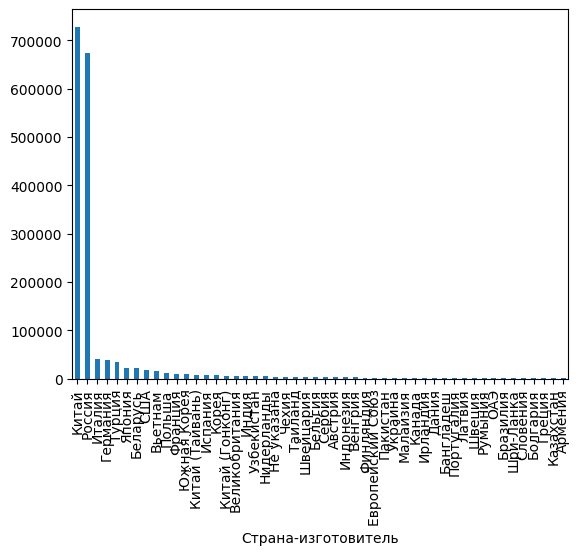

In [26]:
# Топ-50 стран-изготовителей
data['Страна-изготовитель'].dropna().value_counts()[:50].plot(kind='bar')

<Axes: xlabel='Бренд'>

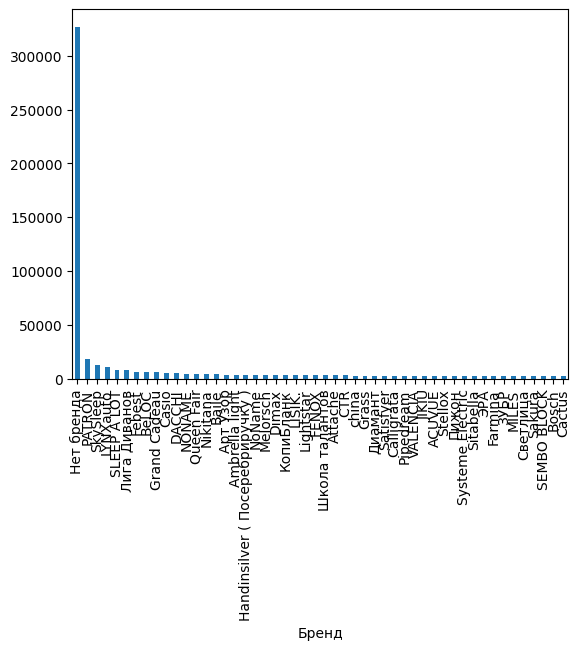

In [27]:
# Топ-50 брендов
data['Бренд'].dropna().value_counts()[:50].plot(kind='bar')

<Axes: xlabel='Бренд'>

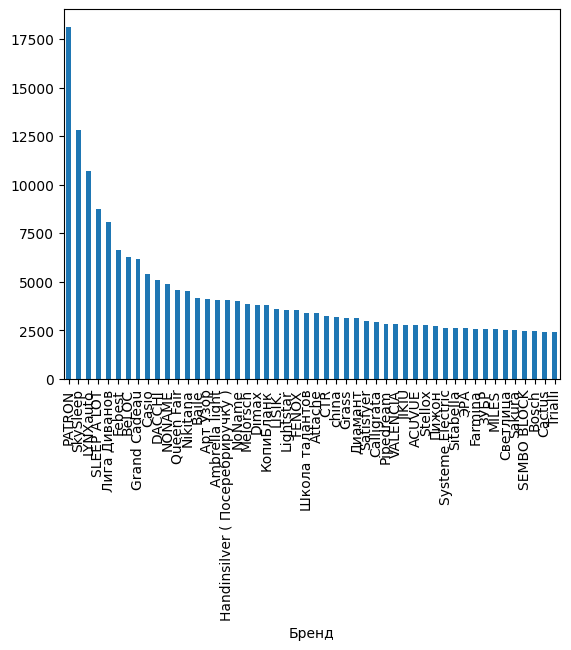

In [28]:
# Топ-50 брендов, за исключением "Нет бренда"
data[data['Бренд'] != 'Нет бренда']['Бренд'].dropna().value_counts()[:50].plot(kind='bar')

<Axes: xlabel='Бренд в одежде и обуви'>

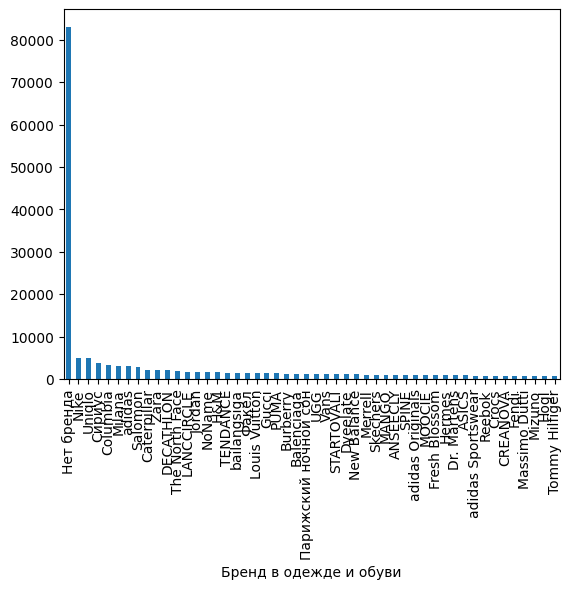

In [34]:
# Топ-50 брендов (обувных)
data['Бренд в одежде и обуви'].dropna().value_counts()[:50].plot(kind='bar')

<Axes: xlabel='Бренд в одежде и обуви'>

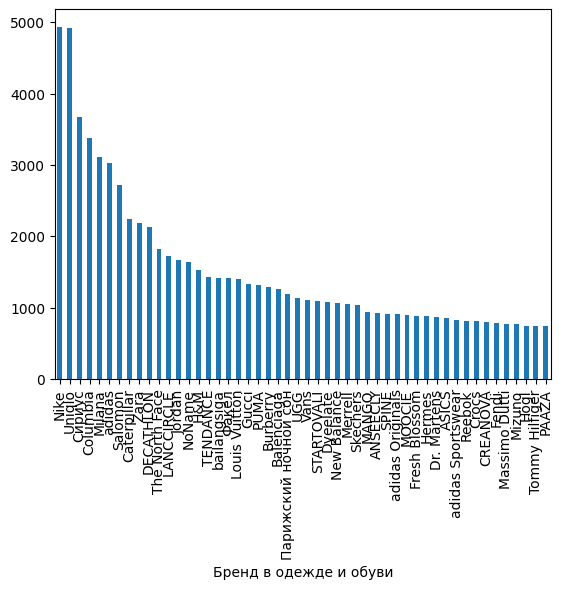

In [33]:
# Топ-50 брендов (обувных), за исключением "Нет бренда"
data[data['Бренд в одежде и обуви'] != 'Нет бренда']['Бренд в одежде и обуви'].dropna().value_counts()[:50].plot(kind='bar')

In [30]:
train_pairs.rename(
    columns={
        'variantid1': 'variantid_1',
        'variantid2': 'variantid_2'
    }, inplace=True
)

test_pairs.rename(
    columns={
        'variantid1': 'variantid_1',
        'variantid2': 'variantid_2'
    }, inplace=True
)

In [31]:
train_df = train_pairs.merge(
    data.add_suffix('_1'), 
    on='variantid_1'
).merge(
    data.add_suffix('_2'), 
    on='variantid_2'
)

test_df = test_pairs.merge(
    data.add_suffix('_1'), 
    on='variantid_1'
).merge(
    data.add_suffix('_2'), 
    on='variantid_2'
)

In [52]:
train_df = train_df[
    ~train_df['category_level_2_1'].isin(
        ['Антиквариат и коллекционирование', 'Ювелирные изделия', 'Автомототехника', 'Фермерское хозяйство']
    )
] # почти пустые категории

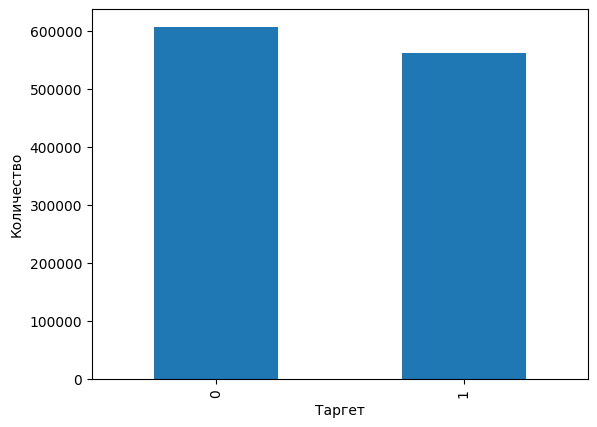

In [53]:
# Распределение таргета
train_df['target'].value_counts().plot(kind='bar')

plt.xlabel('Таргет')
plt.ylabel('Количество')
plt.show()

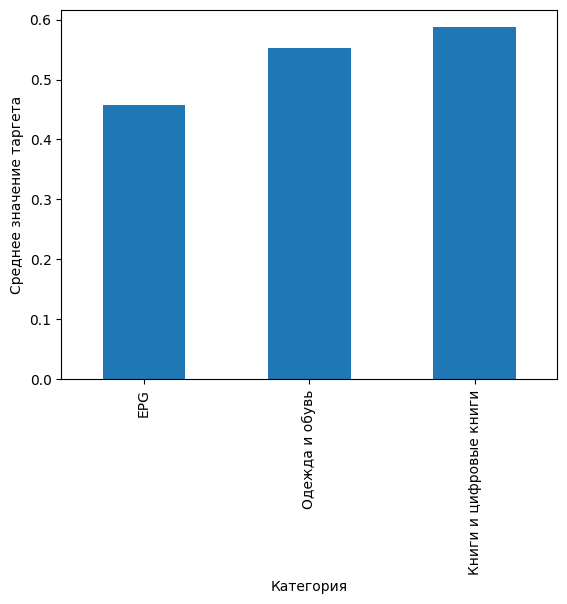

In [76]:
# Среднее значение таргета по категории первого уровня
train_df.groupby('category_level_1_1')['target'].mean().sort_values().plot(kind='bar')

plt.xlabel('Категория')
plt.ylabel('Среднее значение таргета')
plt.show()

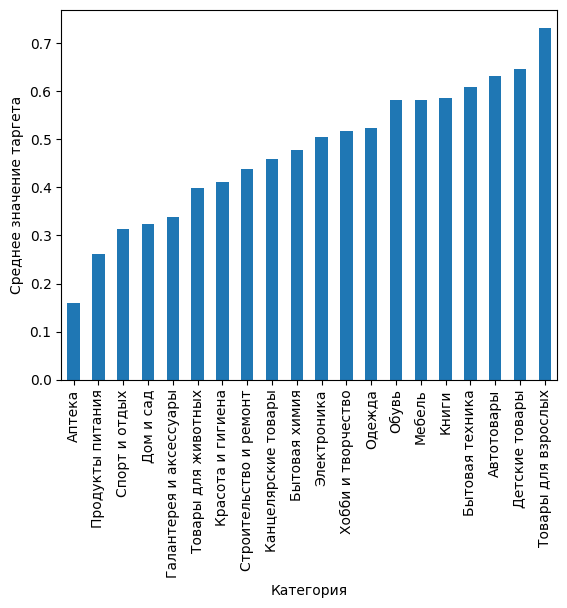

In [58]:
# Среднее значение таргета по категории второго уровня
train_df.groupby('category_level_2_1')['target'].mean().sort_values().plot(kind='bar')

plt.xlabel('Категория')
plt.ylabel('Среднее значение таргета')
plt.show()

In [67]:
# Среднее значение таргета по категории третьего уровня
cat3_targets = train_df.groupby('category_level_3_1')['target'].mean().sort_values()

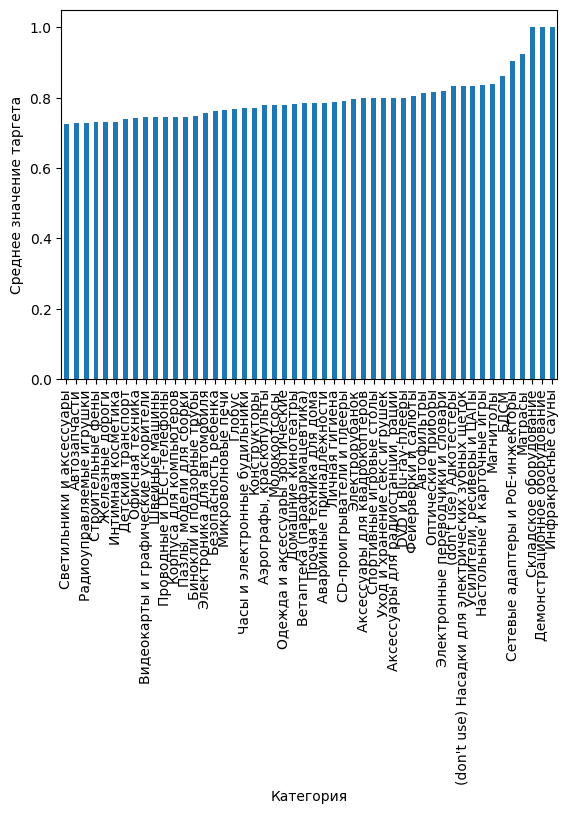

In [69]:
# Категории с самым большим средним значением таргета
cat3_targets[-50:].plot(kind='bar')
plt.xlabel('Категория')
plt.ylabel('Среднее значение таргета')
plt.show()

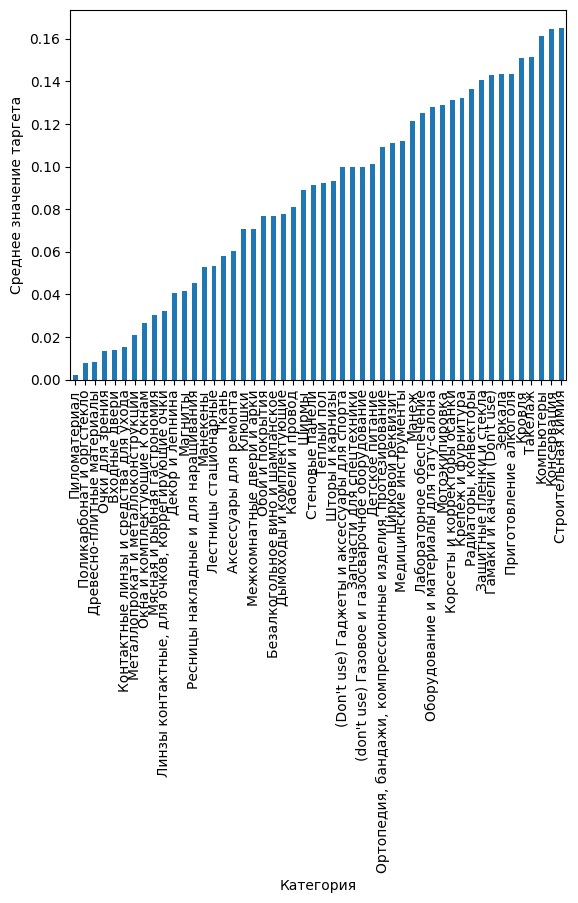

In [75]:
# Категории с самым маленьким средним значением таргета
cat3_targets[21:71].plot(kind='bar') # первые 21 имеют среднее 0
plt.xlabel('Категория')
plt.ylabel('Среднее значение таргета')
plt.show()

In [77]:
# Посмотрим у скольких товаров в тренировочном датасете одинаковый партномер
partnomer_train = train_df[(train_df['Партномер_1'].notna()) & (train_df['Партномер_2'].notna()) & (train_df['Партномер_1'] == train_df['Партномер_2'])]
len(partnomer_train)

13129

In [78]:
# Посмотрим у скольких товаров в тренировочном датасете одинаковый партномер, но при этом не мэтч
len(partnomer_train[partnomer_train['target'] == 0])

3727

In [79]:
# Посмотрим у скольких товаров в тестовом датасете одинаковый партномер
partnomer_test = test_df[(test_df['Партномер_1'].notna()) & (test_df['Партномер_2'].notna()) & (test_df['Партномер_1'] == test_df['Партномер_2'])]
len(partnomer_test)

188

In [80]:
# Посмотрим у скольких товаров в тренировочном датасете разные бренды, но при этом мэтч
brand_train = train_df[(train_df['Бренд_1'].notna()) & (train_df['Бренд_2'].notna()) & (train_df['Бренд_1'] != train_df['Бренд_2'])]
len(brand_train[brand_train['target'] == 1])

70978

In [81]:
# Посмотрим у скольких товаров в тренировочном датасете разные бренды (обувные), но при этом мэтч
brand_2_train = train_df[(train_df['Бренд в одежде и обуви_1'].notna()) & (train_df['Бренд в одежде и обуви_2'].notna()) & (train_df['Бренд в одежде и обуви_1'] != train_df['Бренд в одежде и обуви_2'])]
len(brand_2_train[brand_2_train['target'] == 1])

4321

In [82]:
# Посмотрим у скольких товаров в тренировочном датасете разные типы, но при этом мэтч
type_train = train_df[(train_df['Тип_1'].notna()) & (train_df['Тип_2'].notna()) & (train_df['Тип_1'] != train_df['Тип_2'])]
len(type_train[type_train['target'] == 1])

46799

In [83]:
# Посмотрим у скольких товаров в тренировочном датасете разные цвета, но при этом мэтч
color_train = train_df[(train_df['Цвет товара_1'].notna()) & (train_df['Цвет товара_2'].notna()) & (train_df['Цвет товара_1'] != train_df['Цвет товара_2'])]
len(color_train[color_train['target'] == 1])

35776